# Assignment 4: Hamiltonian Learning of Spin-1/2 Chains
First, we use an simple Hamiltonian as a first approach to our problem.

## Imports

In [ ]:
import functools
import numpy as np
import scipy.linalg
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
import torch.nn as nn

## Definitions

In [ ]:
def kron(args):    
    """
    Definition from 
    Kronecker product with variable-length arguments.
    """
    backend = np if isinstance(args[0], np.ndarray) else __import__("torch")
    return functools.reduce(backend.kron, args)


def paulis():
    """
    Returns the 2x2 Pauli matrices as numpy arrays
    """
    I = np.eye(2, dtype=np.complex128)
    X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)
    return I, X, Y, Z


def single_qubit_measurement_unitary(axis: int) -> np.ndarray:

    """
    Unitary that rotates the measurement basis to the desired axis.
    axis: 0->X, 1->Y, 2->Z
    - If measuring in X: apply H (Hadamard) and then measure in computational basis.
    - If measuring in Y: apply S^† H and then measure in computational basis.
    - If measuring in Z: identity.
    """
    H = np.array([[1, 1], [1, -1]], dtype=np.complex128) / np.sqrt(2) # Hadamard
    Sdg = np.array([[1, 0], [0, -1j]], dtype=np.complex128)  # S^\dagger

    if axis == 0:# X
        return H # rotate to X basis
    elif axis == 1:# Y
        return Sdg @ H # rotate to Y basis
    elif axis == 2:# Z
        return np.eye(2, dtype=np.complex128) # already in Z basis, no rotation needed
    else:
        raise ValueError("axis must be 0 (X), 1 (Y), or 2 (Z)")


def rotate_state_for_pauli_measurement(state: np.ndarray, pauli_obs: np.ndarray) -> np.ndarray:

    """
    Apply U = product_i U_i(pauli_obs[i]) to the state (vector) to convert
    measurement in {X,Y,Z}^n to measurement in the computational basis.
    Input:
    - state: vector of shape (2^n,)
    - pauli_obs: array of shape (n,), entries in {0,1,2} for X,Y,Z respectively
     Output:
     - rotated_state: vector of shape (2^n,) that can be measured in the computational
      basis to get the same statistics as measuring the original state in the specified Pauli bases.
    """
    n = pauli_obs.shape[0]
    U_factors = [single_qubit_measurement_unitary(int(a)) for a in pauli_obs]
    U = kron(U_factors)
    return U @ state



## Hamiltonian Transverse Ising



In this section we explicitly construct the dense matrix of the Transverse Ising Hamiltonian for a chain of $n$ qubits:

$H = a \sum_{i=1}^{n-1} X_i X_{i+1};+; b \sum_{i=1}^{n} Z_i$
- $X_i$ is the Pauli $X$ matrix acting on qubit $i$,
- $Z_i$ is the Pauli $Z$ matrix acting on qubit $i$,
- $a$ is the coupling between neighboring qubits,
- $b$ is the strength of the local field in the $Z$ direction.

In [ ]:
# ============================================================
# 1) Selected Hamiltonian: Transverse Ising (1D chain)
#    H = a * sum_i X_i X_{i+1} + b * sum_i Z_i
# ============================================================
def hamiltonian_ising(n: int, a: float, b: float) -> np.ndarray:
    """
    Construct the transverse Ising Hamiltonian for n qubits with parameters a and b.
     - n: number of qubits
     - a: coupling strength for the XX interaction
     - b: strength of the transverse field in Z direction
     Returns:
     - H: the Hamiltonian as a (2^n, 2^n) numpy array
    """
    I, X, Y, Z = paulis()
    dim = 2**n
    H = np.zeros((dim, dim), dtype=np.complex128) # inicialize hamiltonian as zero matrix

    # XX interactions
    for i in range(n - 1):
        ops = [I] * n # start with identity on all qubits
        ops[i] = X # X on qubit i
        ops[i + 1] = X # X on qubit i+1
        H += a * kron(ops) #

    # Transverse field in Z direction
    for i in range(n):
        ops = [I] * n
        ops[i] = Z
        H += b * kron(ops)  

    # This ensures H is Hermitian (should already be, but just in case of numerical issues)
    H = 0.5 * (H + H.conj().T)
    return H



# ============================================================
# 2) Generate dataset (Using Algorithm 9 from the lecture notes)
#    - easy initial states
#    - times
#    - random Pauli observables
#    - sampling (shots) after rotation to computational basis
# ============================================================
def basis_state(n: int, index: int) -> np.ndarray:
    """This function generates the computational basis state |index> for n qubits.
    For example, for n=3 and index=5 (which is 101 in binary), it returns |101> = |1>⊗|0>⊗|1>."""
    v = np.zeros(2**n, dtype=np.complex128)# initialize a zero vector of length 2^n
    v[index] = 1.0# set the amplitude of the |index> state to 1
    return v


def plus_state(n: int) -> np.ndarray:
    """|+>^{⊗n}"""
    v_plus = np.array([1.0, 1.0], dtype=np.complex128) / np.sqrt(2) # |+> = (|0> + |1>)/sqrt(2)
    return kron([v_plus] * n) 


def random_product_state(n: int, rng: np.random.Generator) -> np.ndarray:
    """
    Random product state: for each qubit, sample a random point on the Bloch sphere and construct the corresponding single-qubit state.
     - n: number of qubits
     - rng: random number generator for reproducibility
     Returns:
     - state: a random product state vector of shape (2^n,) that can be measured in the computational basis."""
    vecs = []
    for _ in range(n):
        theta = rng.uniform(0.0, np.pi) # polar angle
        phi = rng.uniform(0.0, 2 * np.pi) # azimuthal angle
        v = np.array([np.cos(theta / 2), np.exp(1j * phi) * np.sin(theta / 2)], dtype=np.complex128) # single-qubit state on the Bloch sphere = ºcos(theta/2)|0> + e^{i phi} sin(theta/2)|1>
        v = v / np.linalg.norm(v) # normalization
        vecs.append(v)
    return kron(vecs)  


def evolve_state_exact(H: np.ndarray, psi0: np.ndarray, t: float) -> np.ndarray:
    """
    Evolve the state psi0 under the Hamiltonian H for time t using exact matrix exponentiation
        - H: Hamiltonian as a (2^n, 2^n) numpy array
        - psi0: initial state vector of shape (2^n,)
        - t: time to evolve
        Returns:
        - psi_t: the evolved state vector of shape (2^n,) after applying U = exp(-i H t) to psi0
    """
    U = scipy.linalg.expm(-1j * t * H) # unitary evolution operator U = exp(-i H t)
    psi_t = U @ psi0 #º evolved state psi_t = U |psi0>
    psi_t = psi_t / np.linalg.norm(psi_t) # normalization
    return psi_t


def sample_measurements_in_pauli_basis(psi_t: np.ndarray, pauli_obs: np.ndarray, shots: int, rng: np.random.Generator)-> np.ndarray:
    """
    Sample measurement outcomes in the specified Pauli bases by first rotating the state to the computational basis and then sampling according to the probabilities.
        - psi_t: state vector of shape (2^n,) to be measured
        - pauli_obs: array of shape (n,), entries in {0,1,2} for X,Y,Z respectively, specifying the measurement basis for each qubit
        - shots: number of samples to draw
        - rng: random number generator for reproducibility
        Returns:
        - samples: array of shape (shots,) with the sampled measurement outcomes as integers in [0, 2^n - 1], corresponding to the computational basis states.
    """
    psi_rot = rotate_state_for_pauli_measurement(psi_t, pauli_obs) # rotate state to computational basis
    probs = np.abs(psi_rot) ** 2 # probabilities of measuring each computational basis state
    probs = probs / probs.sum() # normalization to ensure they sum to 1
    samples = rng.choice(np.arange(probs.shape[0]), size=shots, p=probs).astype(np.int64) # sample according to the probabilities
    return samples


def dataset_algorithm9(
    n: int,
    true_params: dict,
    num_initial_states: int = 3,
    num_times: int = 20,
    dt: float = 0.2,
    num_paulis: int = 30,
    shots: int = 200,
    seed: int = 0,
):
    """
    Generate dataset using Algorithm 9 from the lecture notes:
    1) Define the true Hamiltonian H_true with the given parameters.
    2) Prepare a set of initial states.
    3) Define a set of times at which to evolve the states.
    4) For each time, sample random local Pauli observables for each qubit.
    5) For each initial state, evolve it under H_true for each time, rotate to the appropriate basis for the sampled Pauli observables,
    and sample measurement outcomes according to the probabilities given by the evolved state.
     - n: number of qubits
     - true_params: dictionary with keys "a" and "b" for the Ising Hamiltonian parameters
     - num_initial_states: how many different initial states to prepare (including the easy ones)
     - num_times: how many different times to evolve the states
     - dt: time step between the evolved states (times will be dt, 2*dt, ..., num_times*dt)
     - num_paulis: how many different random Pauli observables to sample for each time epoch
     - shots: how many measurement samples to draw for each evolved state and Pauli observable
     - seed: random seed for reproducibility
     Returns:
     - dataset: a dictionary containing the generated dataset with keys:
        - "n": number of qubits
        - "true_params": the true parameters of the Hamiltonian
        - "initial_states": array of shape (S, 2^n) with the initial state vectors
        - "times": array of shape (T,) with the times at which the states were evolved
        - "pauli_obs": array of shape (P, n) with the sampled Pauli observables for each time epoch
        - "samples": array of shape (S, T, P, shots) with the sampled measurement outcomes for each initial state, time, and Pauli observable, where each outcome is an integer in [0, 2^n - 1] corresponding to the computational basis states.         
    """
    rng = np.random.default_rng(seed)

    # true Hamiltonian
    H_true = hamiltonian_ising(n=n, a=true_params["a"], b=true_params["b"])

    # initial states: we include some easy ones (|0...0> and |+...+>) and then fill the rest with random product states if needed
    initial_states = []
    if num_initial_states >= 1:
        initial_states.append(basis_state(n, 0))      # |0...0>
    if num_initial_states >= 2:
        initial_states.append(plus_state(n))          # |+...+>
    while len(initial_states) < num_initial_states:
        initial_states.append(random_product_state(n, rng))

    initial_states = np.stack(initial_states, axis=0)  # (S, 2^n)

    # Times at which to evolve the states
    times = dt * (np.arange(1, num_times + 1))  # (T,)

    # Random Pauli observables for each time epoch
    pauli_obs = rng.integers(0, 3, size=(num_paulis, n), endpoint=False)

    # Sample measurements for each initial state, time, and Pauli observable
    S = initial_states.shape[0]
    samples = np.empty((S, num_times, num_paulis, shots), dtype=np.int64)

    for s in range(S):
        psi0 = initial_states[s]
        for ti, t in enumerate(times):
            psi_t = evolve_state_exact(H_true, psi0, float(t))
            for p in range(num_paulis):
                samples[s, ti, p, :] = sample_measurements_in_pauli_basis(psi_t=psi_t, pauli_obs=pauli_obs[p], shots=shots, rng=rng)

    dataset = {
        "n": n,
        "true_params": true_params,
        "initial_states": initial_states,
        "times": times,
        "pauli_obs": pauli_obs,
        "samples": samples,
    }
    return dataset


def save_dataset_npz(dataset: dict, filename: str = "dataset_part2_algorithm9.npz"):
    """Save the dataset dictionary to a compressed .npz file.
     - dataset: the dictionary containing the dataset to save
     - filename: the name of the file to save to (default: "dataset_part2_algorithm9.npz")
     """
    np.savez_compressed(
        filename,
        n=dataset["n"],
        true_params=str(dataset["true_params"]),
        initial_states=dataset["initial_states"],
        times=dataset["times"],
        pauli_obs=dataset["pauli_obs"],
        samples=dataset["samples"],
    )



## Dataset

In [29]:
# ============================================================
# Main execution: generate and save the dataset
# ============================================================
if __name__ == "__main__": 
    n = 8 
    true_params = {"a": 1.0, "b": 0.7}  

    dataset = dataset_algorithm9(
        n=n,
        true_params=true_params,
        num_initial_states=3,
        num_times=20,
        dt=0.2,
        num_paulis=30,
        shots=200,
        seed=42,
    )

    print("initial_states:", dataset["initial_states"].shape)  # (S, 2^n)
    print("times:", dataset["times"].shape)                    # (T,)
    print("pauli_obs:", dataset["pauli_obs"].shape)            # (P, n)
    print("samples:", dataset["samples"].shape)                # (S, T, P, shots)

    save_dataset_npz(dataset, "dataset_part2_algorithm9.npz")
    print("Saved -> dataset_part2_algorithm9.npz")

        # ------------------------------------------------------------
    # Print dataset "head" (sanity check)
    # ------------------------------------------------------------
    print("\n=== DATASET HEAD ===")
    # First initial state
    print("\nInitial state [0] (first 5 amplitudes):")
    print(dataset["initial_states"][0][:5])

    # First few times
    print("\nTimes (first 5):")
    print(dataset["times"][:5])

    # First Pauli observable
    print("\nPauli observable [0] (0=X, 1=Y, 2=Z):")
    print(dataset["pauli_obs"][0])

    # First few measurement samples
    print("\nSamples [state=0, time=0, pauli=0] (first 10 shots):")
    print(dataset["samples"][0, 0, 0, :10])
    print("Cada número es un resultado de medición, es decir, un bitstring medido.")
    print("Ejemplo: 5 -> '00000101' en binario, lo que significa que se midió |0> en qubits 0,2 y |1> en qubits 1,3,...")


initial_states: (3, 256)
times: (20,)
pauli_obs: (30, 8)
samples: (3, 20, 30, 200)
Saved -> dataset_part2_algorithm9.npz

=== DATASET HEAD ===

Initial state [0] (first 5 amplitudes):
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Times (first 5):
[0.2 0.4 0.6 0.8 1. ]

Pauli observable [0] (0=X, 1=Y, 2=Z):
[0 1 2 0 2 2 0 1]

Samples [state=0, time=0, pauli=0] (first 10 shots):
[211  95 193   3 112 114 210 131  85  34]
Cada número es un resultado de medición, es decir, un bitstring medido.
Ejemplo: 5 -> '00000101' en binario, lo que significa que se midió |0> en qubits 0,2 y |1> en qubits 1,3,...


## Hamiltonian Ansatz

In [ ]:
# Ansatz Hamiltonian Transverse Ising
# H_A(c) = c_xx * sum_i X_i X_{i+1} + c_z * sum_i Z_i

def build_ansatz_hamiltonian(n: int, params: np.ndarray) -> np.ndarray:
    """
    Build the dense matrix of the Ansatz Hamiltonian:

        H_A = params[0] * sum_i X_i X_{i+1}
            + params[1] * sum_i Z_i

    Args:
        n (int): number of qubits
        params (array-like): [c_xx, c_z]

    Returns:
        H (np.ndarray): dense Hamiltonian matrix (2^n x 2^n)
    """
    assert len(params) == 2, "Ansatz has exactly two parameters"

    c_xx, c_z = params
    I, X, Y, Z = paulis()

    dim = 2**n
    H = np.zeros((dim, dim), dtype=np.complex128)

    # XX nearest-neighbour terms
    for i in range(n - 1):
        ops = [I] * n
        ops[i] = X
        ops[i + 1] = X
        H += c_xx * kron(ops) 

    # Z field terms
    for i in range(n):
        ops = [I] * n
        ops[i] = Z
        H += c_z * kron(ops)

    # Hermiticity (safety)
    H = 0.5 * (H + H.conj().T)
    return H

# ============================================================
# Assignment 4 — Part 4
# Train a VANILLA Hamiltonian model
#
# Vanilla model:
#  - Ansatz Hamiltonian H_A(c) = c_xx * sum_i X_i X_{i+1} + c_z * sum_i Z_i
#  - Exact unitary evolution U(t) = exp(-i H_A t) via eigendecomposition
#  - Likelihood training on Algorithm-9-style measurement samples
#
# We assume you already generated a dataset dict like:
#   dataset = {
#      "n": n,
#      "true_params": {"a":..., "b":...},
#      "initial_states": (S, 2^n) complex numpy,
#      "times": (T,) float numpy,
#      "pauli_obs": (P, n) int numpy with entries 0/1/2 for X/Y/Z,
#      "samples": (S, T, P, shots) int numpy in [0,2^n-1]
#   }
#
# ============================================================

def kron(args):
    backend = np if isinstance(args[0], np.ndarray) else torch
    return functools.reduce(backend.kron, args)

def paulis_torch(device="cpu"):
    I = torch.eye(2, dtype=torch.complex128, device=device)
    X = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128, device=device)
    Y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128, device=device)
    Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128, device=device)
    return I, X, Y, Z


def single_qubit_measurement_unitary_torch(axis: int, device="cpu") -> torch.Tensor:
    """
    Unitary that rotates the measurement basis to the desired axis.
    """
    H = torch.tensor([[1, 1], [1, -1]], dtype=torch.complex128, device=device) / np.sqrt(2)
    Sdg = torch.tensor([[1, 0], [0, -1j]], dtype=torch.complex128, device=device)

    if axis == 0:
        return H
    elif axis == 1:
        return Sdg @ H
    elif axis == 2:
        return torch.eye(2, dtype=torch.complex128, device=device)
    else:
        raise ValueError("axis must be 0 (X), 1 (Y), or 2 (Z)")


def build_rotation_operator(pauli_obs_row: np.ndarray, device="cpu") -> torch.Tensor:
    """
    Construye U = ⊗_i U_i(pauli_obs[i]) como matriz (2^n, 2^n).
    pauli_obs_row: shape (n,) int in {0,1,2}
    """
    factors = [single_qubit_measurement_unitary_torch(int(a), device=device) for a in pauli_obs_row]
    return kron(factors)  

# ============================================================
# 2) Ansatz Hamiltonian (torch, diferenciable)
# ============================================================
def build_ansatz_hamiltonian_torch(n: int, params: torch.Tensor, device="cpu") -> torch.Tensor:
    """
    H_A = c_xx * sum_i X_i X_{i+1} + c_z * sum_i Z_i
    params: tensor shape (2,) real (stored as complex ok, imag should remain 0)
    """
    c_xx = params[0]
    c_z  = params[1]
    I, X, Y, Z = paulis_torch(device=device)

    dim = 2**n
    H = torch.zeros((dim, dim), dtype=torch.complex128, device=device)

    for i in range(n - 1):
        ops = [I] * n
        ops[i] = X
        ops[i + 1] = X
        H = H + c_xx * kron(ops)  

    for i in range(n):
        ops = [I] * n
        ops[i] = Z
        H = H + c_z * kron(ops)  

    H = 0.5 * (H + H.conj().T)
    return H

def evolve_state_matrix_exp(H: torch.Tensor, psi0: torch.Tensor, t: float) -> torch.Tensor:
    """
    Evolve the state psi0 under Hamiltonian H for time t using exact matrix exponentiation:
    psi(t) = exp(-i H t) psi0
     - H: Hamiltonian as a (2^n, 2^n) torch tensor
     - psi0: initial state vector of shape (2^n,) torch tensor
     - t: time to evolve (float)
     Returns:
     - psi_t: the evolved state vector of shape (2^n,) after applying U = exp(-i H t) to psi0
    """
    U = torch.matrix_exp((-1j * t) * H)
    psi_t = U @ psi0
    psi_t = psi_t / torch.linalg.norm(psi_t)
    return psi_t

def probs_in_measurement_basis(psi_t: torch.Tensor, Urot: torch.Tensor) -> torch.Tensor:
    """
    Given psi(t) in the computational basis, rotate to measurement basis:
     psi_rot = Urot @ psi_t
     probs = |psi_rot|^2
     Returns:
     - probs: tensor of shape (2^n,) with the probabilities of measuring each computational basis state after rotating to the measurement basis defined by Urot.
     These probabilities can be used to sample measurement outcomes in the same way as in the numpy version, but here we return the probabilities directly for use in a differentiable loss function.
     - psi_t: state vector of shape (2^n,) in computational basis
     - Urot: unitary rotation operator of shape (2^n, 2^n) that rotates from the measurement basis to the computational basis
     - probs: tensor of shape (2^n,) with the probabilities of measuring each computational basis state after applying the rotation Urot to psi_t, which corresponds to measuring in the original Pauli basis defined by Urot.
    """
    psi_rot = Urot @ psi_t
    probs = torch.abs(psi_rot) ** 2
    probs = probs / torch.sum(probs)
    return probs


## Init params for Vanilla and NDE

In [31]:
init_params = np.random.uniform(0.2, 1, size=2) # Random init in a reasonable range
print("Initial parameters (c_xx, c_z):", init_params)

Initial parameters (c_xx, c_z): [0.84817489 0.53020945]


## Vanilla

epoch    1/500 | NLL=4.778807 | c_xx=0.8582 (true 1.0000) | c_z=0.5402 (true 0.7000)
epoch    2/500 | NLL=4.752281 | c_xx=0.8682 (true 1.0000) | c_z=0.5502 (true 0.7000)
epoch    3/500 | NLL=4.725839 | c_xx=0.8782 (true 1.0000) | c_z=0.5602 (true 0.7000)
epoch    4/500 | NLL=4.698695 | c_xx=0.8883 (true 1.0000) | c_z=0.5702 (true 0.7000)
epoch    5/500 | NLL=4.669872 | c_xx=0.8984 (true 1.0000) | c_z=0.5802 (true 0.7000)
epoch    6/500 | NLL=4.639317 | c_xx=0.9085 (true 1.0000) | c_z=0.5902 (true 0.7000)
epoch    7/500 | NLL=4.607505 | c_xx=0.9187 (true 1.0000) | c_z=0.6003 (true 0.7000)
epoch    8/500 | NLL=4.575404 | c_xx=0.9290 (true 1.0000) | c_z=0.6103 (true 0.7000)
epoch    9/500 | NLL=4.543572 | c_xx=0.9393 (true 1.0000) | c_z=0.6203 (true 0.7000)
epoch   10/500 | NLL=4.512106 | c_xx=0.9496 (true 1.0000) | c_z=0.6303 (true 0.7000)
epoch   11/500 | NLL=4.482204 | c_xx=0.9599 (true 1.0000) | c_z=0.6402 (true 0.7000)
epoch   12/500 | NLL=4.454679 | c_xx=0.9701 (true 1.0000) | c_z=0

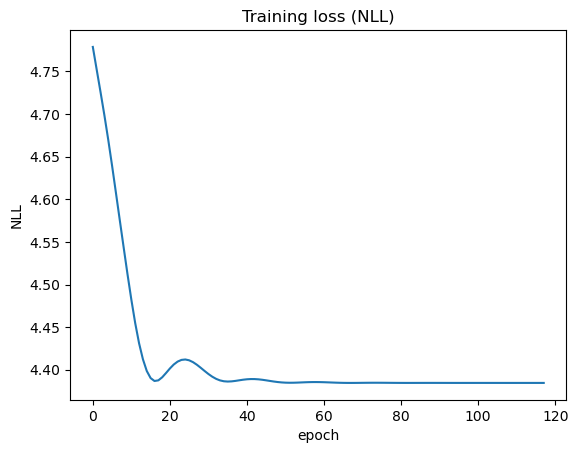

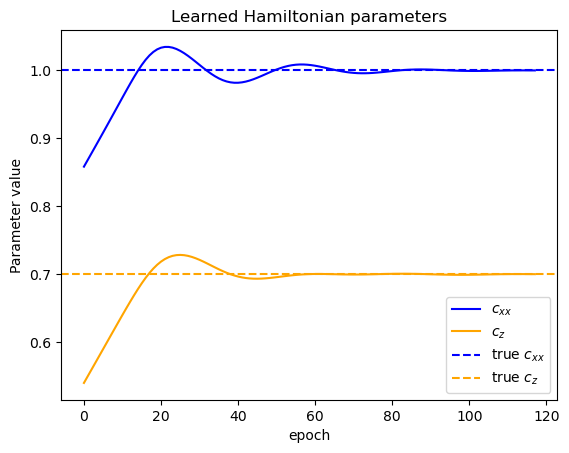

In [32]:
# ============================================================
# 5) Train the model by minimizing NLL on the samples
# ============================================================
def train_vanilla_model(
    dataset: dict,
    num_epochs: int = 300,
    lr: float = 5e-2,
    eps: float = 1e-12,
    device: str = "cpu",
    init_params=None,               
    patience_stop: int = 50,
    min_delta: float = 1e-5,
):
    """
    Train the vanilla Hamiltonian model by minimizing the negative log-likelihood (NLL) of the observed samples in the dataset.
     - dataset: the dataset dictionary generated by dataset_algorithm9, containing "n", "true_params", "initial_states", "times", "pauli_obs", and "samples".
     - num_epochs: maximum number of optimization epochs
     - lr: learning rate for the optimizer
     - eps: small constant to avoid log(0) in the likelihood calculation
     - device: "cpu" or "cuda" for training
     - init_params: optional initial parameters for the Hamiltonian (array-like of shape (2,)). If None, initialized to zeros.
     - patience_stop: number of epochs to wait for improvement in the loss before early stopping
     - min_delta: minimum change in the loss to qualify as an improvement for early stopping
     Returns:
     - history: a dictionary containing the training history with keys:
        - "loss": array of shape (epochs_done,) with the NLL loss at each epoch
        - "params": array of shape (epochs_done, 2) with the learned parameters at each epoch
        - "true": array of shape (2,) with the true parameters for reference
     The function trains the model by iterating over the dataset, computing the NLL loss based on the probabilities of the observed samples under the current Hamiltonian parameters, and updating the parameters
    """
    n = int(dataset["n"])
    times = dataset["times"]                 # (T,) numpy
    pauli_obs = dataset["pauli_obs"]         # (P,n) numpy
    samples = dataset["samples"]             # (S,T,P,shots) numpy
    init_states = dataset["initial_states"]  # (S,2^n) numpy complex

    S, T, P, shots = samples.shape
    dim = 2**n

    # Convert initial states to torch
    init_states_t = torch.tensor(init_states, dtype=torch.complex128, device=device)

    # Precompute rotation matrices for each pauli observable row (P of them)
    Urots = []
    for p in range(P):
        Urots.append(build_rotation_operator(pauli_obs[p], device=device))
    Urots = torch.stack(Urots, dim=0)  # (P, dim, dim)

    # Parameters to learn: [c_xx, c_z] (real)
    if init_params is None:
        init_params = np.zeros(2, dtype=np.float64)

    params = torch.nn.Parameter(
        torch.tensor(init_params, dtype=torch.float64, device=device)
    )

    opt = torch.optim.Adam([params], lr=lr)

    loss_hist = []
    param_hist = []

    true_cxx = float(dataset["true_params"]["a"])
    true_cz  = float(dataset["true_params"]["b"])

    # Early stopping variables
    best_loss = float("inf")
    epochs_since_improve = 0

    for epoch in range(num_epochs): # training loop
        opt.zero_grad() # reset gradients

        # Build H(params)
        H = build_ansatz_hamiltonian_torch(n, params.to(torch.complex128), device=device)

        total_logp = torch.zeros((), dtype=torch.float64, device=device) # scalar to accumulate log probabilities
        count = 0 # total number of samples counted for averaging

        for s in range(S):
            psi0 = init_states_t[s]  # (dim,)
            for ti in range(T): # iterate over times
                t = float(times[ti])
                psi_t = evolve_state_matrix_exp(H, psi0, t) # this is the state at time t under the current Hamiltonian parameters

                for p in range(P):
                    probs = probs_in_measurement_basis(psi_t, Urots[p])  # probabilities of measuring each computational basis state for the current Pauli observable
                    idx = torch.as_tensor(samples[s, ti, p], dtype=torch.long, device=device)  
                    p_samp = probs[idx]  # probabilities of the observed samples under the current model

                    # To avoid log(0), we clamp the probabilities to a minimum value of eps before taking the log.
                    p_samp = torch.clamp(p_samp, min=eps)

                    total_logp = total_logp + torch.sum(torch.log(p_samp))# accumulate log probabilities
                    count += shots

        nll = -total_logp / count
        nll.backward()
        opt.step()

        loss_val = float(nll.detach().cpu().item())
        loss_hist.append(loss_val)
        param_hist.append(params.detach().cpu().numpy().copy())

        print(
            f"epoch {epoch+1:4d}/{num_epochs} | NLL={loss_val:.6f} | "
            f"c_xx={param_hist[-1][0]:.4f} (true {true_cxx:.4f}) | "
            f"c_z={param_hist[-1][1]:.4f} (true {true_cz:.4f})"
        )

        # --- Early stopping ---
        if loss_val < best_loss - min_delta:
            best_loss = loss_val
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        if epochs_since_improve >= patience_stop:
            print(
                f"[EarlyStopping] Stopping training after {epoch+1} epochs without improvement of at least "
                f"(min_delta={min_delta}) in {patience_stop} iterations "
                f"best_loss={best_loss:.6f}"
            )
            break

    history = {
        "loss": np.array(loss_hist),
        "params": np.array(param_hist),  # (epochs_done, 2)
        "true": np.array([true_cxx, true_cz]),
    }
    return history


def plot_training(history: dict):
    loss = history["loss"]
    params = history["params"]
    true_cxx, true_cz = history["true"]

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("epoch")
    plt.ylabel("NLL")
    plt.title("Training loss (NLL)")
    plt.show()

    # Params
    plt.figure()
    plt.plot(np.arange(len(params)), params[:, 0], color="blue", label=r"$c_{xx}$")
    plt.plot(np.arange(len(params)), params[:, 1], color="orange", label=r"$c_z$")
    plt.axhline(true_cxx, linestyle="--", label=r"true $c_{xx}$", color="blue")
    plt.axhline(true_cz,  linestyle="--", label=r"true $c_z$", color="orange")
    plt.xlabel("epoch")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters")
    plt.legend()
    plt.show()

# ============================================================
# Execution: load dataset, train model, and plot results
# ============================================================
history = train_vanilla_model(dataset, num_epochs=500, lr=1e-2, device="cpu", init_params=init_params)
plot_training(history)

## Neural ODE

In [ ]:
# ============================================================
# Neural ODE: RK4 integrator for Schrödinger equation
# dpsi/dt = -i H psi
# ============================================================
def rk4_step(psi, t, dt, H):
    # k1 = f(psi)
    k1 = (-1j) * (H @ psi)
    # k2 = f(psi + dt/2 k1)
    k2 = (-1j) * (H @ (psi + 0.5 * dt * k1))
    # k3
    k3 = (-1j) * (H @ (psi + 0.5 * dt * k2))
    # k4
    k4 = (-1j) * (H @ (psi + dt * k3))
    psi_next = psi + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    # normalize
    psi_next = psi_next / torch.linalg.norm(psi_next)
    return psi_next

def plot_training_nde_eff(history: dict):
    loss = history["loss"]
    c_eff = history["c_eff"]   # effective parameters
    true_cxx, true_cz = history["true"]

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("epoch")
    plt.ylabel("NLL")
    plt.title("Training loss (Neural ODE)")
    plt.grid(alpha=0.3)
    plt.show()

    # Parameters 
    plt.figure()
    plt.plot(np.arange(len(c_eff)), c_eff[:, 0], color="red", linewidth=2, label=r"$c_{xx}^{eff}$")
    plt.plot(np.arange(len(c_eff)), c_eff[:, 1],  color="blue", linewidth=2, label=r"$c_z^{eff}$")
    plt.axhline(true_cxx, linestyle="--", color="red", label=r"true $c_{xx}$")
    plt.axhline(true_cz, linestyle="--", color="blue", label=r"true $c_z$")
    plt.xlabel("epoch")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (effective)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def plot_training_nde(history: dict):
    loss = history["loss"]
    c = history["c"]
    true_cxx, true_cz = history["true"]

    # Loss
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("epoch")
    plt.ylabel("NLL")
    plt.title("Training loss (NDE)")
    plt.show()

    # Parameters
    plt.figure()
    plt.plot(np.arange(len(c)), c[:, 0], color="red", label=r"$c_{xx}$ (NDE)")
    plt.plot(np.arange(len(c)), c[:, 1], color="blue", label=r"$c_z$ (NDE)")
    plt.axhline(true_cxx, linestyle="--", color="red", label=r"true $c_{xx}$")
    plt.axhline(true_cz, linestyle="--", color="blue", label=r"true $c_z$")
    plt.xlabel("epoch")
    plt.ylabel("Parameter value")
    plt.title("Learned Hamiltonian parameters (NDE)")
    plt.legend()
    plt.show()


def integrate_ode_rk4(psi0, times_torch, H):
    """
    Integrate from t=0 to times_torch[-1] and return psi at each time in times_torch.
    Assumes times are increasing and start > 0 is ok.
    """
    # We integrate in small steps between requested time points
    states = []
    t_prev = 0.0
    psi = psi0

    for t in times_torch:
        t = float(t.item())
        dt = t - t_prev
        # one RK4 step over the full interval 
        psi = rk4_step(psi, t_prev, dt, H)
        states.append(psi)
        t_prev = t

    return torch.stack(states, dim=0)  # (T, dim)

class CoeffNet(nn.Module):
    # Neural network to map from current coefficients to effective coefficients
    def __init__(self, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )

    def forward(self, c):
        return self.net(c)



## Train NDE

[NDE] Step    1/500 | NLL=4.780880 | c_eff_xx=0.8765 (true 1.0000) | c_eff_z=0.5176 (true 0.7000) | c=[0.8582,0.5402] dc=[0.0283,-0.0126]
[NDE] Step    2/500 | NLL=4.645575 | c_eff_xx=0.8915 (true 1.0000) | c_eff_z=0.5817 (true 0.7000) | c=[0.8679,0.5501] dc=[0.0333,0.0415]
[NDE] Step    3/500 | NLL=4.517217 | c_eff_xx=0.9155 (true 1.0000) | c_eff_z=0.6409 (true 0.7000) | c=[0.8776,0.5598] dc=[0.0476,0.0908]
[NDE] Step    4/500 | NLL=4.420064 | c_eff_xx=0.9466 (true 1.0000) | c_eff_z=0.6953 (true 0.7000) | c=[0.8874,0.5684] dc=[0.0689,0.1355]
[NDE] Step    5/500 | NLL=4.403361 | c_eff_xx=0.9835 (true 1.0000) | c_eff_z=0.7404 (true 0.7000) | c=[0.8960,0.5738] dc=[0.0960,0.1720]
[NDE] Step    6/500 | NLL=4.439010 | c_eff_xx=1.0184 (true 1.0000) | c_eff_z=0.7620 (true 0.7000) | c=[0.9016,0.5759] dc=[0.1224,0.1882]
[NDE] Step    7/500 | NLL=4.458983 | c_eff_xx=1.0402 (true 1.0000) | c_eff_z=0.7619 (true 0.7000) | c=[0.9040,0.5757] dc=[0.1386,0.1860]
[NDE] Step    8/500 | NLL=4.450459 | c_e

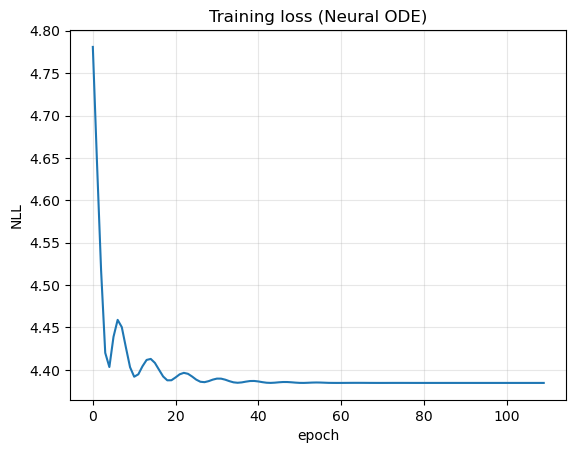

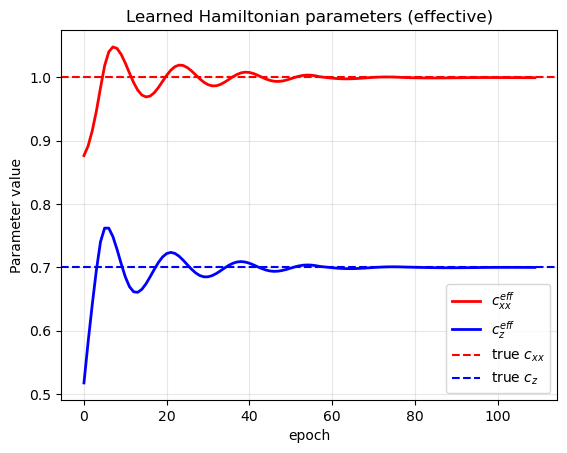

In [ ]:
# ============================================================
# Neural ODE model: H_A(c_eff) where c_eff = c + NN_phi(c)
# We train c and NN_phi parameters to minimize NLL on the dataset samples.
# We use RK4 to integrate the Schrödinger equation with the time-dependent Hamiltonian H_A(c_eff).
# The effective parameters c_eff allow the model to learn a correction to the original Ansatz Hamiltonian, 
# potentially capturing more complex dynamics and improving fit to the data.
# ============================================================

def rk4_step(psi, dt, H):
    """
    One RK4 step for the Schrödinger equation dψ/dt = -i H ψ.

    IMPORTANT:
    We do NOT renormalize ψ inside the RK4 substeps.
    The Schrödinger equation with Hermitian H conserves the norm exactly,
    and renormalizing at each substep introduces an artificial nonlinearity
    that can bias the dynamics and flatten gradients during training.
    """
    k1 = (-1j) * (H @ psi)
    k2 = (-1j) * (H @ (psi + 0.5 * dt * k1))
    k3 = (-1j) * (H @ (psi + 0.5 * dt * k2))
    k4 = (-1j) * (H @ (psi + dt * k3))

    psi_next = psi + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return psi_next

def integrate_ode_rk4(psi0, times_torch, H, m=20):
    """
    Integrates the Schrödinger equation using RK4.

    Renormalization is applied ONLY when storing the state at the requested
    observation times, not during intermediate RK4 substeps.
    """
    states = []
    t_prev = 0.0
    psi = psi0

    for t in times_torch:
        t_target = float(t.item())
        dt_big = t_target - t_prev
        dt = dt_big / m

        for _ in range(m):
            psi = rk4_step(psi, dt, H)
            t_prev += dt

        # Renormalize once per observation time (defensive, numerical stability)
        psi = psi / torch.linalg.norm(psi)
        states.append(psi)

    return torch.stack(states, dim=0)

def train_neural_ode_model(
    dataset: dict,
    num_steps: int = 300,
    lr: float = 5e-2,
    eps: float = 1e-12,
    device: str = "cpu",
    hidden: int = 32,
    dc_scale: float = 0.05,
    m: int = 20,
    regularization: float = 0.001,
    init: list = [0.5, 0.5],
    patience_stop: int = 50,    
    min_delta: float = 1e-5,    
):
    """his function trains the Neural ODE model by optimizing both the base coefficients c and the neural network parameters 
    that define the correction to the coefficients (dc)."""
    n = int(dataset["n"])
    times = torch.tensor(dataset["times"], dtype=torch.float64, device=device)  # (T,)
    pauli_obs = dataset["pauli_obs"]         # numpy (P,n)
    samples = dataset["samples"]             # numpy (S,T,P,shots)
    init_states = dataset["initial_states"]  # numpy (S,2^n) complex

    S, T, P, shots = samples.shape
    dim = 2**n

    # initial states to torch complex
    init_states_t = torch.tensor(init_states, dtype=torch.complex128, device=device)

    # precompute rotation matrices 
    Urots = []
    for p in range(P):
        Urots.append(build_rotation_operator(pauli_obs[p], device=device))
    Urots = torch.stack(Urots, dim=0)  # (P, dim, dim)

    # trainable coefficients (theta) + NN params (phi)
    c = nn.Parameter(torch.tensor(init, dtype=torch.float64, device=device))
    net = CoeffNet(hidden=hidden).to(device) # neural network to learn correction to coefficients

    opt = torch.optim.Adam(list(net.parameters()) + [c], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20, min_lr=1e-4) # learning rate scheduler that reduces lr if loss plateaus

    true_cxx = float(dataset["true_params"]["a"])
    true_cz  = float(dataset["true_params"]["b"])

    # histories for plotting
    loss_hist = []
    c_hist = []
    dc_hist = []
    c_eff_hist = []

    # Early stopping variables
    best_loss = float("inf")
    steps_since_improve = 0

    for step in range(num_steps):
        # here starts the training loop for the Neural ODE model
        opt.zero_grad()

        # NN_phi acts on coefficients
        dc = dc_scale * net(c) 
        c_eff = c + dc

        # Build H_tilde = H_A(c_eff)
        H = build_ansatz_hamiltonian_torch(n, c_eff.to(torch.complex128), device=device) # build the Hamiltonian with the effective parameters

        total_logp = torch.tensor(0.0, dtype=torch.float64, device=device) # scalar to accumulate log probabilities
        count = 0

        for s in range(S):# iterate over initial states
            psi0 = init_states_t[s]  # (dim,)

            # Integrate ODE to get psi(t) for all requested times
            psi_ts = integrate_ode_rk4(psi0, times, H, m)

            for ti in range(T):
                # Loop over Pauli observables and samples to compute log-likelihood
                psi_t = psi_ts[ti] # state at time t for initial state s under current H
                for p in range(P): # iterate over Pauli observables
                    probs = probs_in_measurement_basis(psi_t, Urots[p])
                    idx = torch.tensor(samples[s, ti, p], dtype=torch.long, device=device)
                    p_samp = probs[idx]
                    total_logp = total_logp + torch.sum(torch.log(p_samp + eps))
                    count += shots

        nll = -total_logp / count
        reg = regularization * torch.sum(dc**2)
        loss = nll + reg

        loss.backward()
        opt.step()

        # Logging
        loss_val = float(loss.detach().cpu().item())
        loss_hist.append(loss_val)
        c_hist.append(c.detach().cpu().numpy().copy())
        dc_hist.append(dc.detach().cpu().numpy().copy())
        c_eff_hist.append(c_eff.detach().cpu().numpy().copy())

        print(f"[NDE] Step {step+1:4d}/{num_steps} | NLL={loss_val:.6f} | "
              f"c_eff_xx={c_eff_hist[-1][0]:.4f} (true {true_cxx:.4f}) | "
              f"c_eff_z={c_eff_hist[-1][1]:.4f} (true {true_cz:.4f}) | "
              f"c=[{c_hist[-1][0]:.4f},{c_hist[-1][1]:.4f}] dc=[{dc_hist[-1][0]:.4f},{dc_hist[-1][1]:.4f}]")

        # Scheduler
        scheduler.step(loss.detach())

        # Early stopping check
        if loss_val < best_loss - min_delta:
            best_loss = loss_val
            steps_since_improve = 0
        else:
            steps_since_improve += 1

        if steps_since_improve >= patience_stop:
            print(f"[EarlyStopping] Parando en step {step+1} porque la loss no mejora "
                  f"(min_delta={min_delta}) en {patience_stop} iteraciones.")
            break

    history = {
        "loss": np.array(loss_hist),
        "c": np.array(c_hist),
        "dc": np.array(dc_hist),
        "c_eff": np.array(c_eff_hist),
        "true": np.array([true_cxx, true_cz]),
    }
    return history
history_nde_modificado = train_neural_ode_model(
    dataset,
    num_steps=500,
    lr=1e-2,
    hidden=32,
    dc_scale=0.1,
    m=20,
    regularization=0.001,
    init=init_params,
    patience_stop=50,   
    min_delta=1e-5      
)

plot_training_nde_eff(history_nde_modificado)


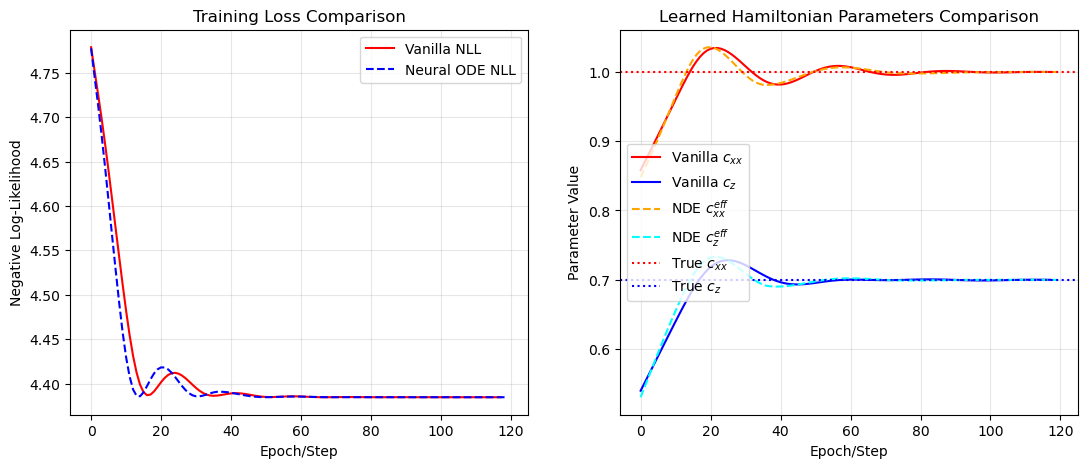

In [36]:
def plot_all_results(history_vanilla: dict, history_nde: dict):
    # here we plot in the same graphic the training curves for the vanilla model, the NDE model, and the NDE with effective parameters to compare their performance visually.
    history_vanilla = history_vanilla
    history_nde = history_nde_modificado
    loss_vanilla = history_vanilla["loss"]
    loss_nde = history_nde["loss"]
    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(np.arange(len(loss_vanilla)), loss_vanilla, label="Vanilla NLL", color="red", linestyle="-")
    ax1.plot(np.arange(len(loss_nde)), loss_nde, label="Neural ODE NLL", color="blue", linestyle="--")
    ax1.set_xlabel("Epoch/Step")    
    ax1.set_ylabel("Negative Log-Likelihood")
    ax1.set_title("Training Loss Comparison")
    ax1.legend()
    ax1.grid(alpha=0.3)


    # also we compare the learned parameters c_xx and c_z for both models against the true parameters to see how well each model is able to recover the underlying Hamiltonian parameters from the data.
    c_vanilla = history_vanilla["params"]
    c_nde = history_nde["c_eff"]
    true_cxx, true_cz = history_vanilla["true"]
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(np.arange(len(c_vanilla)), c_vanilla[:, 0], label=r"Vanilla $c_{xx}$", color="red", linestyle="-")
    ax2.plot(np.arange(len(c_vanilla)), c_vanilla[:, 1], label=r"Vanilla $c_z$", color="blue", linestyle="-")
    ax2.plot(np.arange(len(c_nde)), c_nde[:, 0], label=r"NDE $c_{xx}^{eff}$", color="orange", linestyle="--")
    ax2.plot(np.arange(len(c_nde)), c_nde[:, 1], label=r"NDE $c_z^{eff}$", color="cyan", linestyle="--")
    ax2.axhline(true_cxx, linestyle=":", color="red", label=r"True $c_{xx}$")
    ax2.axhline(true_cz, linestyle=":", color="blue", label=r"True $c_z$")
    ax2.set_xlabel("Epoch/Step")
    ax2.set_ylabel("Parameter Value")
    ax2.set_title("Learned Hamiltonian Parameters Comparison")
    ax2.legend()
    ax2 .grid(alpha=0.3)
    plt.show()

plot_all_results(history, history_nde_modificado)